# Neural Architecture Search for Large Language Models

Neural Architecture Search (NAS) is an effective framework to design neural network architectures automatically.
This notebook demonstrates how to utilize NAS for compressing a large language model that has been fine-tuned for a specific target task. The main objective is to reduce the model size while maintaining performance as much as possible. To achieve this, we search for sub-networks within the model that jointly optimize the parameter count and validation error.

Sub-networks can be defined in various ways. In this context, we consider subsets of multi-head attention and fully-connected layers, with a reduced number of heads in the multi-head attention layer and units in the intermediate layers.

Our NAS approach consists of two steps:

1. Initial fine-tuning of the pre-trained model on the target task using weight-sharing based NAS training strategies. The pre-trained model serves as a 'super-network' that encompasses a large, finite set of sub-networks. To prevent sub-networks from co-adapting, we modify the fine-tuning process by updating only specific parts of the network (i.e., subsets of all layers) in each update step.

2. In the second step, we employ multi-objective search through [SageMaker Automated Model Tuning (AMT)](https://aws.amazon.com/sagemaker/automatic-model-tuning/) to identify a set of sub-networks that offer an optimal trade-off between parameter count and validation error for the target task.

Finally, we can visualize the so-called **Pareto set** of architectures that optimally balance between parameter count and validation error, and select the best-suited model that strikes the right balance between model size and validation error for us.

**Limitations:**

- Currently, the notebook limited to the BERT model family.
- We exclusively focus on supervised fine-tuning using labeled datasets.

In [10]:
import os
import sagemaker
import numpy as np
import json

from datetime import datetime

from sagemaker.pytorch import PyTorch
from sagemaker.huggingface import HuggingFace
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter
from sagemaker import get_execution_role
from sagemaker.session import Session

## Dataset 

For illustration purposes, we use the [Recognizing Textual Entailment](https://aclweb.org/aclwiki/Recognizing_Textual_Entailment) dataset from the [GLUE](https://gluebenchmark.com/) benchmarking suite. For simplicity, we load the dataset via the [dataset library](https://huggingface.co/docs/datasets/index) from HuggingFace inside our training script.
The goal of this dataset is to identify whether the meaning of one sentence can be infered from the other sentence. 
Example sentence pair:
 
sentence 1:
*Only a week after it had no comment on upping the storage capacity of its Hotmail e-mail service, Microsoft early Thursday announced it was boosting the allowance to 250MB to follow similar moves by rivals such as Google, Yahoo, and Lycos.*

sentence 2:
*Microsoft's Hotmail has raised its storage capacity to 250MB.*

In [2]:
seed = 42

hyperparameters = dict()

hyperparameters["seed"] = seed
hyperparameters["output_dir"] = "/opt/ml/checkpoints"
hyperparameters["task_name"] = "rte"

## Split Dataset in Training / Validation

As mentioned earlier, after fine-tuning our 'super-network' on the training dataset, we proceed with a multi-objective search to identify the optimal set of sub-networks that optimally balance between generalization performance and parameter count. Since we cannot directly compute generalization performance, we approximate it by measuring accuracy on a hold-out validation dataset.

To achieve this, we split the original training dataset from GLUE into an training/validation set. The training set is exclusively used for fine-tuning purposes, while the validation data is employed for the subsequent multi-objective search.

## Pre-trained Model

We use the [pre-trained BERT model](https://huggingface.co/bert-base-cased) from the HuggingFace hub, which consists of 12 layer with 12 heads in each multi-head attention layers and 3072 units in the fully connected layers. See [Devlin et. al.](https://aclanthology.org/N19-1423/) for a more detailed description of the model. 

In [3]:
model_type = "bert-base-cased"
hyperparameters["model_name_or_path"] = model_type

## Train weight-sharing based Super-Network

We now fine-tune our pre-training network, i.e super-network with the following hyperparameters. We have to pass an additional argument to specify if our dataset is regression or not (determines the loss function)

In [4]:
hyperparameters["per_device_train_batch_size"] = 8
hyperparameters["per_device_eval_batch_size"] = 8
hyperparameters["learning_rate"] = 2e-05
hyperparameters["num_train_epochs"] = 5
hyperparameters["save_strategy"] = "epoch"
hyperparameters[
    "is_regression"
] = False  # set this to True if your dataset is a regression dataset, for example STSB

We will save the checkpoint of the model on S3, such that we can load it later in the second phase for the multi-objective search.

In [ ]:
session = Session()
s3_bucket = session.default_bucket()
s3_bucket_prefix = "nas_amt/model_checkpoint"
s3_path = f"s3://{s3_bucket}/{s3_bucket_prefix}"

sm_args = dict(
    entry_point="training.py",
    source_dir=os.path.abspath(""),
    instance_type="ml.g4dn.xlarge",
    instance_count=1,
    py_version="py39",
    framework_version="1.13",
    transformers_version="4.26",
    max_run=3600 * 72,
    role=get_execution_role(),
    checkpoint_local_path="/opt/ml/checkpoints",
    hyperparameters=hyperparameters,
    checkpoint_s3_uri=s3_path,
)

est = PyTorch(**sm_args)
est.fit()

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker.estimator:SMDebug Does Not Currently Support                         Distributed Training Jobs With Checkpointing Enabled
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-08-08-08-18-01-334


2023-08-08 08:18:02 Starting - Starting the training job...
2023-08-08 08:18:16 Starting - Preparing the instances for training......
2023-08-08 08:19:23 Downloading - Downloading input data......
2023-08-08 08:20:18 Training - Downloading the training image...............
2023-08-08 08:22:43 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-08 08:22:55,920 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-08 08:22:55,942 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-08 08:22:55,954 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-08-08 08:22:55,958 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-08-08 08:22:57,206 sagemaker-training-toolkit INFO     Installing dependencies f

## Multi-objective search for sub-networks

After the fine-tuning process, we begin the multi-objective search by sampling random sub-networks using AMT. A sub-network is defined by its number of layers, heads, and units in the intermediate fully connected layers. To access a sub-network, we place a binary mask over the super-network and mask out all components (i.e., heads, units) that are not part of the sub-network. Note that, HuggingFace transformers needs the hidden size to be a multiple of the number of head. We cannot change the hidden size, and hence the number of heads has to be in [1, 3, 6, 12].

In contrast to single-objective optimization, in the multi-objective setting, we typically do not have a single solution that simultaneously optimizes all objectives. Instead, we aim to collect a set of solutions that *dominate* all other solutions in at least one objective.

Now we can start the multi-objective search through AMT. We sample a total of 100 random sub-networks (defined by the parameter `max_jobs`) and evaluate 10 networks simultaneously (defined by `max_parallel_jobs`). The code to load the model checkpoint and evaluate the sub-network is available in the `evaluate_subnetwork.py` script.

In [11]:
# Maximum number of sub-networks we will evaluate
max_jobs = 100
max_parallel_jobs = 10

# Entry point script to load the super-network and evaluate a sub-network
entry_point = "evaluate_subnetwork.py"

# Command line arguments for the entry point script
hyperparameters = {"model_name_or_path": model_type, "output_dir": "./tmp", "task_name": "rte"}

# Define the metric we want to maximize
metric_definitions = [
    {"Name": "num-parameters", "Regex": "number of parameters: ([0-9\\.]+)"},
    {"Name": "validation-performance", "Regex": "validation score: ([0-9\\.]+)"},
]

# Define HuggingFace estimator
estimator = HuggingFace(
    entry_point=entry_point,
    source_dir="./",
    instance_type="ml.g4dn.xlarge",  # instance types for the SageMaker training jobs
    instance_count=1,
    py_version="py39",
    framework_version="1.13",
    pytorch_version="1.13",
    transformers_version="4.26",
    max_run=3600 * 72,
    role=get_execution_role(),
    volume_size=125,
    model_uri=s3_path,
    hyperparameters=hyperparameters,
)


current_time = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
tuning_job_name = f"nas-search-{current_time}"

# Search space to define sub-networks
hyperparameter_ranges = {
    "num_layers": IntegerParameter(0, 12),
    # To meet HuggingFace constraints, we can only set the number of head to these values
    "num_heads": CategoricalParameter([1, 3, 6, 12]),
    "num_units": IntegerParameter(0, 3072),
}

# Define AMT Tuner object
my_tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name="validation-performance",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=max_jobs,
    strategy="Random",
    random_seed=seed,
    max_parallel_jobs=max_parallel_jobs,
)

# Start hyperparameter tuning job
my_tuner.fit(job_name=tuning_job_name)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.


Using provided s3_resource


INFO:sagemaker:Creating hyperparameter tuning job with name: nas-search-08-08-2023-08-43-31


..........................................................................................................................................................................................................................................................................!


## Visualize Results

To visualize our results, we parse AMT's history to collect all configurations of sub-networks and the corresponding metrics:

In [12]:
history = my_tuner.analytics().dataframe()
data = []
configs = []
for i, t in enumerate(my_tuner.analytics().training_job_summaries()):
    jn = t["TrainingJobName"]
    df = sagemaker.analytics.TrainingJobAnalytics(jn).dataframe()

    row = history[history["TrainingJobName"] == jn]
    config = {
        "num-heads": int(row["num_heads"].iloc[0].strip('"')),
        "num-layers": int(row["num_layers"]),
        "num-units": int(row["num_units"]),
    }
    configs.append(config)

    p = []
    for j, metric in enumerate(metric_definitions):
        metric_name = metric["Name"]
        if "metric_name" not in df.keys():
            continue

        if metric_name == "validation-performance":
            y = 1 - float(df[df["metric_name"] == metric_name]["value"])
        else:
            y = float(df[df["metric_name"] == metric_name]["value"])
        p.append(y)
    if len(p) > 0:
        data.append(p)

data = np.array(data)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from I

We now visualize the Pareto set, which represents the optimal set of sub-networks that dominate all other sub-networks in at least one metric. This implies that when we move from one sub-network of the Pareto set to another, we must either sacrifice performance or model size but improve the other.

Ultimately, the Pareto set provides us the flexibility to choose the sub-network that best suits our preferences. We can decide how much we want to reduce the size of our network and how much performance we are willing to sacrifice.

INFO:matplotlib.font_manager:generated new fontManager


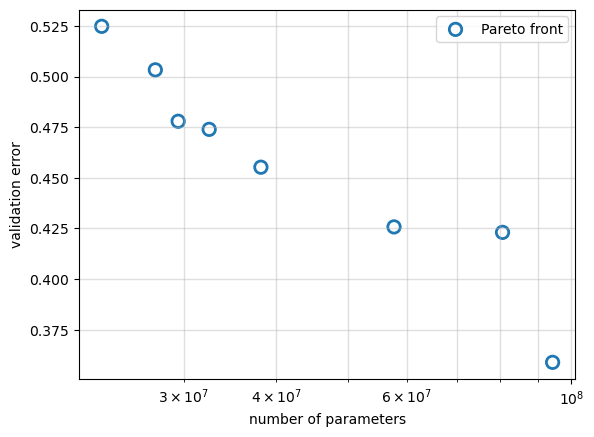

In [13]:
import matplotlib.pyplot as plt
from multi_objective import get_pareto_optimal

idx = get_pareto_optimal(data)
x = data[idx, 0]
y = data[idx, 1]

plt.scatter(
    x, y, marker="o", s=80, facecolors="none", edgecolors="C0", linewidth=2, label="Pareto front"
)
plt.xlabel("number of parameters")
plt.ylabel("validation error")
plt.legend()
plt.xscale("log")
plt.grid(linewidth="1", alpha=0.4, which="both")

## Deploy Model

Base on the Pareto front above, we can select the best model for our use case and deploy it on an endpoint.

In [24]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data='s3://sagemaker-us-west-2-770209394645/nas_amt/model_checkpoint/model.tar.gz',  # path to your trained SageMaker model
   role=get_execution_role(),                                            # IAM role with permissions to create an endpoint
   transformers_version="4.26",                           # Transformers version used
   pytorch_version="1.13",                                # PyTorch version used
   py_version='py39',       
   entry_point='inference.py',
    source_dir="./",
    env={'SM_HPS' : json.dumps(configs[0])}
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [ ]:
# deploy model to SageMaker Inference
import logging
logging.basicConfig(level=logging.INFO)
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type="ml.g4dn.xlarge"
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-2-770209394645/nas_amt/model_checkpoint/model.tar.gz), script artifact (./), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-770209394645/huggingface-pytorch-inference-2023-08-08-09-54-42-747/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: huggingface-pytorch-inference-2023-08-08-09-55-22-090
INFO:sagemaker:Creating endpoint-config with name huggingface-pytorch-inference-2023-08-08-09-55-22-714
INFO:sagemaker:Creating endpoint with name huggingface-pytorch-inference-2023-08-08-09-55-22-714


------

In [ ]:
data = {
   "inputs": [('No Weapons of Mass Destruction Found in Iraq Yet', 'Weapons of Mass Destruction Found in Iraq.')]
}

predictor.predict(data)

Once we are done we can delete the endpoint

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()